In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# Bonds

In [2]:
class ZeroCouponBonds:
    
    def __init__(self, principal, maturity, interest_rate):
        # principal amount
        self.principal = principal
        # date to maturity
        self.maturity = maturity
        # market interest rate (discounting)
        self.interest_rate = interest_rate / 100
        
    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n
    
    def calculate_price(self):
        return self.present_value(self.principal, self.maturity)
    
if __name__ == '__main__':
    
    bond = ZeroCouponBonds(1000, 2, 4)
    print("Price of the bond in dollars: %.2f" % bond.calculate_price())

Price of the bond in dollars: 924.56


In [3]:
class CouponBond:
    
    def __init__(self, principal, rate, maturity, interest_rate):
        self.principal = principal
        self.rate = rate /100
        self.maturity = maturity
        self.interest_rate = interest_rate / 100
        
    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n
    
    def calculate_price(self):
        
        price = 0
        
        # discount the coupon payments
        for t in range(1, self.maturity+1):
            price = price + self.present_value(self.principal * self.rate, t)
            
        # discount principal amount
        price = price + self.present_value(self.principal, self.maturity)
        
        return price
    
if __name__ == '__main__':
    
    bond = CouponBond(1000, 10, 3, 4)
    print("Bond price: %.2f" % bond.calculate_price())

Bond price: 1166.51


# Markowitz Model

In [7]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random weights (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [5]:
# historical data - define START and END dates
start_date = '2016-01-01'
end_date = '2023-01-01'

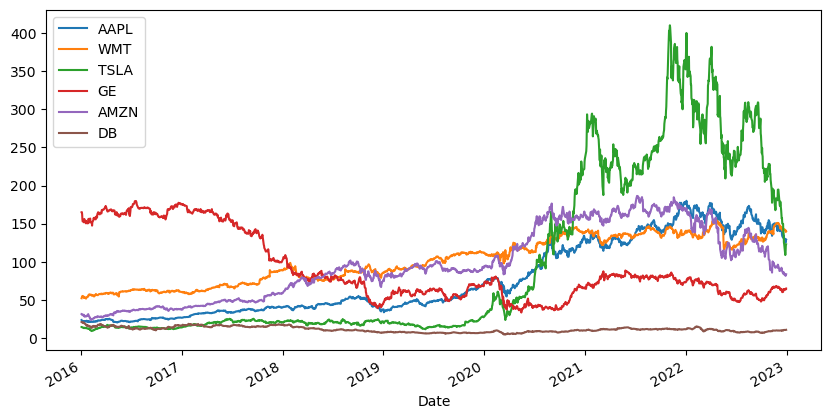

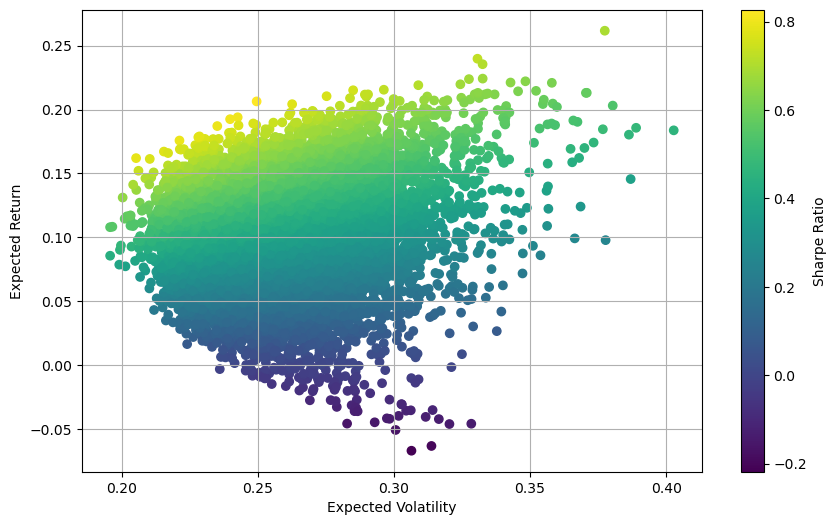

Optimal portfolio:  [0.461 0.457 0.083 0.    0.    0.   ]
Expected return, volatility and Sharpe ratio [0.20039581 0.22264177 0.90008181]


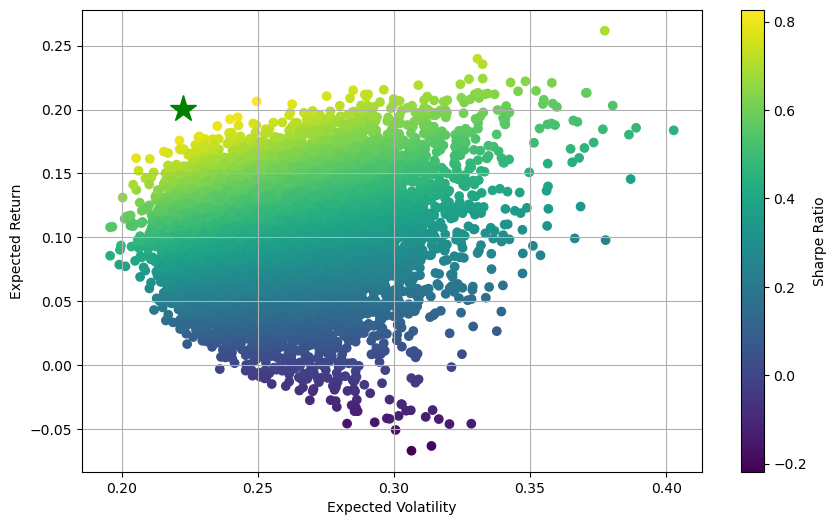

In [15]:
def download_data():
    # name of the stock (key) - stock values (2016-2023) as the values
    stock_data = {}
    
    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10,5))
    plt.show()

def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data/data.shift(1))
    return log_return[1:]

def show_statistics(returns):
    # instead of daily metrics we are after annual etrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()
    
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    
    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# scipy optimize module can find the minimum of a given function
# the maximum of f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# what are the constraints? The sum of weights is 1
# when f(x)=0, we want to minimize the function f
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0,1) for _ in range(len(stocks)))
    return optimization.minimize(fun = min_function_sharpe, x0 = weights[0], args = returns, method = 'SLSQP', bounds = bounds, constraints = constraints)

def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio", statistics(optimum['x'].round(3),returns))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(optimum['x'], rets)[0], 'g*', markersize = 20.0)
    plt.show()    
    
if __name__ == '__main__':
    
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

# Capital Asset Pricing Model

In [7]:
class CAPM:
    
    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        
        data ={}
        
        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker ['Adj Close']
            
        return pd.DataFrame(data)
    
    def initialize(self):
        
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()
        
        self.data = pd.DataFrame({'s_adjclose':stock_data[self.stocks[0]],
                                  'm_adjclose':stock_data[self.stocks[1]]})
        
        # logarithmic monthly returns
        self.data[['s_returns','m_returns']] = np.log(self.data[['s_adjclose','m_adjclose']]/
                                                     self.data[['s_adjclose','m_adjclose']].shift(1))
        
        # remove the NaN values
        self.data = self.data[1:]
        
    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0,1] / covariance_matrix[1,1]
        print("Beta from formula", beta)
        
if __name__ == '__main__':
    
    capm = CAPM(['IBM','^GSPC'],'2018-01-01', '2023-01-01')
    capm.initialize()
    capm.calculate_beta()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula 0.8856495083392736


The portfolio is less risky, and hence has less return, than the market since our beta value indicates the stock market risk is lower than that of an average stock.